In [ ]:
%load_ext autoreload
%autoreload 2
from model import *
from neurons import *
from synaptics import *
from utils import *
from protocols import *
from pyvis.network import Network
res = .1
plt.style.use(['dark_background'])


In [ ]:
snn = SNNModel()
snn.generate_model('config.txt')

In [ ]:
nx.draw(snn.graph, node_color=snn.color_map, node_size=40)
labels = nx.get_edge_attributes(snn.graph, 'weight')
pos = nx.graphviz_layout(snn.graph)
nx.drawing.nx_agraph.draw_networkx_edge_labels(snn.graph, pos, edge_labels=labels)

In [ ]:
net = Network(notebook = True, cdn_resources = "remote",
                bgcolor = "#222222",
                font_color = "white",
                height = "750px",
                width = "100%",
)
G = snn.spit_for_pyvis()
print(G)
net.from_nx(G)
net.show('graph.html')

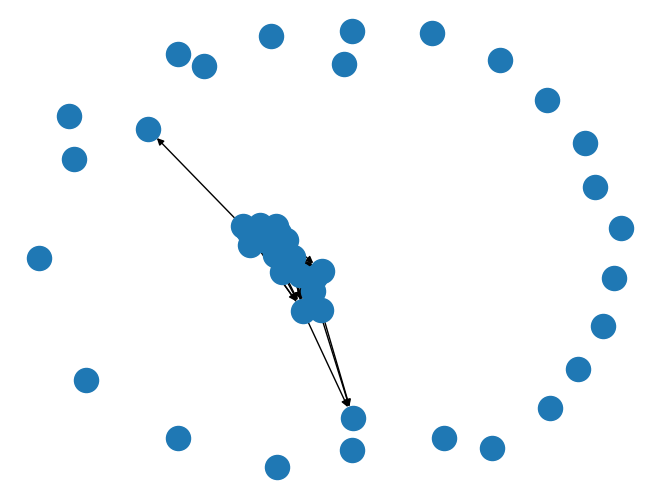

In [12]:
#test = nx.gnp_random_graph(0, .1, seed=None, directed=True)
test = snn.spit_for_pyvis()
nx.draw(test)

In [ ]:
pre_neu = Izhikevich(I=5, preset='CH', resolution=res, noise=0, tau=10)
post_neu = Izhikevich(preset='RS', resolution=res, noise=0, tau=10)
syn = Synapse(pre_neu, post_neu, slow_tau=100, lr=.1, scale=5)
syn.set_weight_manually(0.5)
time = 1000
short_single_synapse(pre_neu, post_neu, syn, time, rule='t_stdp_forgetting')

In [ ]:
pre_neu = Spikes_at_will(awaiting_time=10, refresh_time=30)
post_neu = Spikes_at_will(awaiting_time=12, refresh_time=30)
syn = Synapse(pre_neu, post_neu, slow_tau=100, lr=.5, scale=1)
syn.set_weight_manually(weight=.3)
time = 100
short_single_synapse(pre_neu, post_neu, syn, time, rule='pair_stdp')

In [ ]:
pre_neu = Probability_neuron(I=.01, tau=10)
post_neu = Probability_neuron(tau=10)
syn = Synapse(pre_neu, post_neu, slow_tau=100, lr=.1, scale=.01)
syn.set_weight_manually(0.5)
time = 100
short_single_synapse(pre_neu, post_neu, syn, time, rule='t_stdp')

In [ ]:
neu = Probability_neuron(I=.01)
time = 100
t = np.arange(int(time / res)) * res
sps = []
for i in range(int(time / res)):
    sps.append(neu.dynamics())

In [ ]:
neu.apply_current(-100)
neu.dynamics()
sps1 = []
vs1 = []
for i in range(int(time / res)):
    sps1.append(neu.dynamics())
    vs1.append(neu.v)
    if i == int(0 / res):
        neu.apply_current(.1506)
plt.plot(t, vs1)

In [ ]:
neu.apply_current(0)
neu.dynamics()
sps1 = []
vs1 = []
for i in range(int(time / res)):
    sps1.append(neu.dynamics())
    vs1.append(neu.v)
plt.plot(t, vs1)

In [ ]:
def dev_test(neuron, time, timings, currents, default_current=0):
    t = np.arange(int(time / neuron.resolution)) * neuron.resolution
    vs = []
    spikes = []
    Is = []
    var_idx = 0
    for step in range(len(t)):
        #neuron.apply_current(default_current)
        if len(timings) > var_idx:
            if step == int(timings[var_idx] / neuron.resolution):
                neuron.apply_current(currents[var_idx])
                var_idx += 1
        spikes.append(neuron.dynamics())
        Is.append(neuron.I)
        vs.append(neuron.v)
        
    return vs, Is, spikes,t 

In [ ]:
time = 200
timings = [50, 51, 52]
currents = [0, 100, 0]
neu1 = Izhikevich(I=0, preset='RZ', resolution=res)
vs, Is, spikes, t = dev_test(neu1, time, timings, currents, default_current=0)

In [ ]:
def show_stats(vs, Is, spikes, t, fwidth=15, fheight=9):
    figure, axis = plt.subplots(3, 1)
    figure.set_figwidth(fwidth)
    figure.set_figheight(fheight)
    voltage = axis[0]
    cur = axis[1]
    spks = axis[2]
    voltage.plot(t, vs)
    voltage.set_title('Voltage')
    cur.plot(t, Is)
    cur.set_title('Input current')
    spks.plot(t, spikes)
    spks.set_title('Spikes')

In [ ]:
show_stats(vs, Is, spikes, t)

In [ ]:
def dev_two(pre, post, time, ap_scale=1):
    t = np.arange(int(time / pre.resolution)) * pre.resolution
    vs_pre = []
    spikes_pre = []
    Is_pre = []
    vs_post = []
    spikes_post = []
    Is_post = []
    var_idx = 0
    for step in range(len(t)):
        #neuron.apply_current(default_current)
        ap = pre.dynamics()
        spikes_pre.append(ap)
        Is_pre.append(pre.I)
        vs_pre.append(pre.v)
        post.apply_current(ap * ap_scale)
        spikes_post.append(post.dynamics())
        Is_post.append(post.I)
        vs_post.append(post.v)
        
    return vs_pre, Is_pre, spikes_pre, vs_post, Is_post, spikes_post, t

In [ ]:
res = .1
time = 500
neu_pre = Izhikevich(I=4, preset='CH', resolution=res)
neu_post = Izhikevich(I=0, preset='RZ', resolution=res)
neu_post.u = 0
vs_pre, Is_pre, spikes_pre, vs_post, Is_post, spikes_post, t = dev_two(neu_pre, neu_post, time=time, ap_scale=-100)

In [ ]:
show_stats(vs_pre, Is_pre, spikes_pre, t)

In [ ]:
show_stats(vs_post, Is_post, spikes_post, t)

In [ ]:
def simulate_single(neu, time, ap_scale=1):
    t = np.arange(int(time / neu.resolution)) * neu.resolution
    vs = []
    spikes = []
    Is = []
    for step in range(len(t)):
        ap = neu.dynamics()
        spikes.append(ap * ap_scale)
        Is.append(neu.I)
        vs.append(neu.v)
        
    return vs, Is, spikes, t

In [ ]:
def simulate_several(pre, post, time, ap_scale=[1]):
    t = np.arange(int(time / post.resolution)) * post.resolution
    vs_pre = []
    spikes_pre = []
    Is_pre = []
    vs_post = []
    spikes_post = []
    Is_post = []
    var_idx = 0
    for neus in range(len(pre)):
        vs = []
        spikes = []
        Is = []
        for step in range(len(t)):
            #neuron.apply_current(default_current)
            ap = pre[neus].dynamics()
            spikes.append(ap)
            Is.append(pre[neus].I)
            vs.append(pre[neus].v)
        spikes_pre.append(spikes)
        Is_pre.append(Is)
        vs_pre.append(vs)

    aps = np.array(spikes_pre)
    aps = aps.sum(0)
    print(aps.shape)
    for step in range(len(t)):
        post.apply_current(aps[step] * ap_scale)
        spikes_post.append(post.dynamics())
        Is_post.append(post.I)
        vs_post.append(post.v)
        
    return vs_pre, Is_pre, spikes_pre, vs_post, Is_post, spikes_post, t

In [ ]:
def show_stats_many(vs, Is, spikes, t, fwidth=15, fheight=9):
    figure, axis = plt.subplots(3, 1)
    figure.set_figwidth(fwidth)
    figure.set_figheight(fheight)
    for i in range(len(vs)):
        voltage = axis[0]
        cur = axis[1]
        spks = axis[2]
        voltage.plot(t, vs[i])
        cur.plot(t, Is[i])
        spks.plot(t, spikes[i])
    voltage.set_title('Voltage')
    cur.set_title('Input current')
    spks.set_title('Spikes')

In [ ]:
res = .1
time = 1000
neu0 = Izhikevich(I=4, preset='RS', resolution=res)
neu1 = Izhikevich(I=5, preset='RS', resolution=res)
neu2 = Izhikevich(I=6, preset='RS', resolution=res)
neu3 = Izhikevich(I=7, preset='CH', resolution=res)
neu_post = Izhikevich(I=0, preset='RZ', resolution=res)
neus = [neu0, neu1, neu2, neu3]
vs_pre, Is_pre, spikes_pre, vs_post, Is_post, spikes_post, t = simulate_several(neus, neu_post, time=time, ap_scale=-100)

In [ ]:
show_stats_many(vs_pre, Is_pre, spikes_pre, t)

In [ ]:
show_stats(vs_post, Is_post, spikes_post, t)

In [ ]:
# BCM

class BCM:
    def __init__(self, neu1, neu2, k=.1):
        self.w = 0
        self.neu1 = neu1
        self.neu2 = neu2
        self.k = k
        self.theta = neu2

    def change(self):
        dw = self.neu2 * (self.neu2 - self.theta) * self.neu1 -self.k * self.ww